In [1]:
# import sys
# sys.path.append('..')

In [2]:
from utility import load_dataset, load_model_with_ckpt, make_one_graph
import draw_utils

/opt/miniconda3/envs/SPGIE/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import torch
import torchvision.transforms as VT
from torchvision.datasets import MNIST
ori_dataset = MNIST('~/data', train=False, transform=VT.ToTensor())
dataset = load_dataset('mnist', train=False)

----- Loading test dataset -----


In [4]:
# hidden_dim = 20
# ckpt_name = '/home/dragonchen/SPGIE_thesis/mlruns/0/1c9779a75ea94423be73437ac34200df/artifacts/best.pt'
hidden_dim = 64
ckpt_name = '/home/dragonchen/SPGIE_thesis/mlruns/0/5e3d764e3cf548efb10a5713c76999e4/artifacts/best.pt'

aggr = 'add'
pool = 'max'

device = torch.device('cpu')
model = load_model_with_ckpt(
    input_dim=dataset.num_features,
    hidden_dim=hidden_dim,
    output_dim=dataset.num_classes,
    drn_k=4, aggr=aggr, pool=pool,
    device=device,
    ckpt_name=ckpt_name,
)

Pooling with max
Using self-loops
There are 2 aggregation layers


In [5]:
img_idx = 4
img_ori, lbl = ori_dataset[img_idx]
compactness = 0.1
img_sp, node2map = make_one_graph(
    torch.permute(img_ori, (1, 2, 0)), channel_axis=None,
    compactness=compactness,
)
img_sp.y = torch.tensor(lbl)

# img_sp = dataset[img_idx]

In [6]:
img_ori.shape

torch.Size([1, 28, 28])

In [7]:
# temp = dataset[0]
# temp = img_sp
# print(temp.x.dtype)
# print(temp.edge_index.dtype)
# print(temp.y.dtype)
# print(temp.pos.dtype)

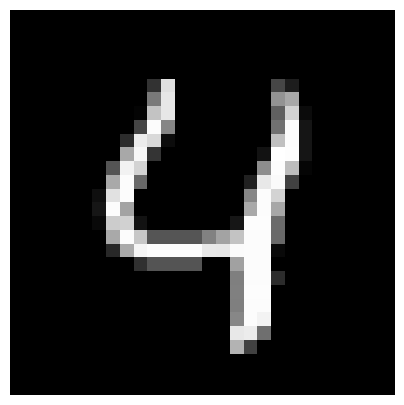

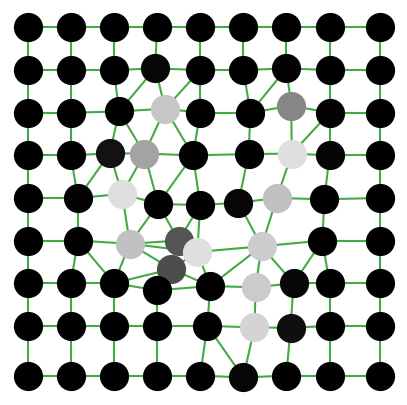

In [8]:
import matplotlib.pyplot as plt

# original
draw_utils.show_original(img_ori)

# superpixel version
draw_utils.draw_superpixel_from_graph(
    img_sp.pos, img_sp.x[:, 2].unsqueeze(dim=1),
    img_sp.edge_index,
)
plt.show()

In [9]:
img_sp.batch = torch.zeros(img_sp.x.shape[0]).long()
img_sp = img_sp.to(device)

out = model(img_sp).detach().cpu()

print('true', lbl)
print('pred', out.argmax(1).item())

true 4
pred 3


In [10]:
# torch.manual_seed(1340)
for i, c in enumerate(torch.softmax(out, 1).tolist()[0]):
    print(f'{i} {c:.04f}')

0 0.0000
1 0.0000
2 0.0000
3 1.0000
4 0.0000
5 0.0000
6 0.0000
7 0.0000
8 0.0000
9 0.0000


In [36]:
import sys
sys.path.append('..')
from models.graph_phase import test
from torch_geometric.loader import DataLoader

test_dev = torch.device('cuda:0')
loader = DataLoader(dataset, batch_size=128, shuffle=False)
acc, _ = test(model.to(test_dev), loader, device=test_dev, mlflow_log=False)
print(f'Got {acc * 100:.2f}% acc on testing set.')
model = model.to(device)

100%|██████████| 79/79 [00:07<00:00, 10.99it/s]

Got 97.31% acc on testing set.


## Start Explaining

In [11]:
from PIL import Image
plt.rcParams['figure.facecolor'] = '#fffafa'
import networkx as nx
from skimage.segmentation import slic, mark_boundaries

In [12]:
from models.jit_drn_model import (
    knn_graph, to_undirected, normalized_cut_2d,
    graclus_cluster,
#     aggr_pool, aggr_pool_x,
    global_pool_aggr
)

In [13]:
from torch_scatter import scatter
from torch_geometric.typing import OptTensor, Optional, Tuple
from torch import Tensor
from torch_geometric.nn.pool.consecutive import consecutive_cluster
from torch_geometric.nn.pool.pool import pool_batch

def _aggr_pool_x(cluster, x, aggr: str, size: Optional[int] = None):
    """Call into scatter with configurable reduction op"""
    return scatter(x, cluster, dim=0, dim_size=size, reduce=aggr)

def global_pool_aggr(x, batch: OptTensor, aggr: str, size: Optional[int] = None):
    """Global pool via passed aggregator: 'mean', 'add', 'max'"""
    if batch is None and size is None:
        raise Exception('Must provide at least one of "batch" or "size"')
    if batch is not None:
        size = int(batch.max().item() + 1)
    assert batch is not None
    return scatter(x, batch, dim=0, dim_size=size, reduce=aggr)

# this function is specialized compared to the more general non-jittable version
# in particular edge_attr can be removed since it is always None
def aggr_pool(cluster, x, batch: OptTensor, aggr: str) -> Tuple[Tensor, OptTensor]:
    """jit-friendly version of max/mean/add pool"""
    global node_hist
    print('c1', cluster.shape)
    print(cluster[:20])
    c1 = cluster.detach().cpu()
    cluster, perm = consecutive_cluster(cluster)
    print('c2', cluster.shape)
    print(cluster[:20])
    print('perm', perm.shape)
    print('perm', perm[:10])
    c2 = cluster.detach().cpu()
    p = perm.detach().cpu()
    node_hist.append({
        'c1': c1,
        'c2': c2,
        'p': p
    })

    x = _aggr_pool_x(cluster, x, aggr)
    if batch is not None:
        batch = pool_batch(perm, batch)
    return x, batch

def aggr_pool_x(cluster, x, batch: OptTensor, aggr: str, size: Optional[int] = None) -> Tuple[Tensor, OptTensor]:
    """*_pool_x with configurable aggr method"""
    global node_hist
    if batch is None and size is None:
        raise Exception('Must provide at least one of "batch" or "size"')
    if size is not None and batch is not None:
        batch_size = int(batch.max().item()) + 1
        return _aggr_pool_x(cluster, x, aggr, batch_size * size), None

    print('c1', cluster.shape)
    print(cluster)
    c1 = cluster.detach().cpu()
    cluster, perm = consecutive_cluster(cluster)
    print('c2', cluster.shape)
    print(cluster)
    print('perm', perm.shape)
    print('perm', perm)
    c2 = cluster.detach().cpu()
    p = perm.detach().cpu()
    node_hist.append({
        'c1': c1,
        'c2': c2,
        'p': p
    })
    
    x = _aggr_pool_x(cluster, x, aggr)
    if batch is not None:
        batch = pool_batch(perm, batch)

    return x, batch

start x torch.Size([81, 64])
c1 torch.Size([81])
tensor([ 0,  1,  2,  2,  4,  5,  6,  6,  8,  9,  0, 11, 12, 13,  5, 15, 16,  8,
        18, 19])
c2 torch.Size([81])
tensor([ 0,  1,  2,  2,  3,  4,  5,  5,  6,  7,  0,  8,  9, 10,  4, 11, 12,  6,
        13, 14])
perm torch.Size([45])
perm tensor([10,  1,  3,  4, 14,  7, 17, 20, 22, 41])


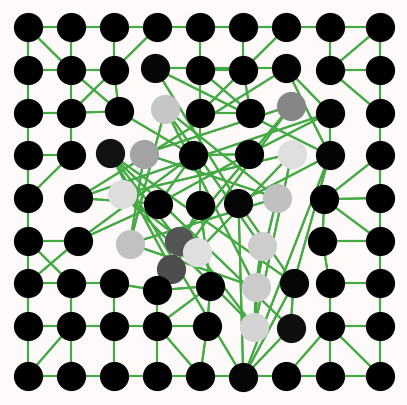

c1 torch.Size([45])
tensor([ 0,  1,  2,  3,  4,  3,  6,  0,  1,  9, 10, 11, 12, 13, 14,  2, 16, 11,
        18, 14,  4,  9, 22, 23,  6, 18, 26, 13, 16, 29, 30, 31, 32, 26, 34, 31,
        22, 37, 37, 30, 32, 41, 42, 41, 42])
c2 torch.Size([45])
tensor([ 0,  1,  2,  3,  4,  3,  5,  0,  1,  6,  7,  8,  9, 10, 11,  2, 12,  8,
        13, 11,  4,  6, 14, 15,  5, 13, 16, 10, 12, 17, 18, 19, 20, 16, 21, 19,
        14, 22, 22, 18, 20, 23, 24, 23, 24])
perm torch.Size([25])
perm tensor([ 7,  8, 15,  5, 20, 24, 21, 10, 17, 12, 27, 19, 28, 25, 36, 23, 33, 29,
        39, 35, 40, 34, 38, 43, 44])
global x tensor([[ 5.8616e+02, -3.9999e+00,  2.3063e+02, -4.0000e+00, -3.9999e+00,
          4.0231e+01,  1.8895e+04,  1.0592e+04, -3.9997e+00,  1.0354e+01,
          3.1562e+01, -3.9974e+00, -3.2190e+00,  5.0665e+01,  1.4090e+02,
          3.6467e+03, -3.9995e+00,  3.1511e+00,  6.0446e+01,  2.7252e-01,
         -3.7730e+00,  4.5262e+01,  7.4444e+03, -1.1986e+00,  1.4664e+04,
          1.6931e+01,  7.78

[[-1955.32421875,
  -156.281005859375,
  -1090.33740234375,
  0.0,
  -3107.7216796875,
  -647.7442626953125,
  -119.6771240234375,
  -1964.5147705078125,
  -1611.501708984375,
  -3358.34423828125]]

In [14]:
import torch.nn.functional as F

torch.manual_seed(100)

drn = model.drn # get the model layer
x = img_sp.x
batch = img_sp.batch

# draw_superpixel_from_graph(x, gd.edge_index)

x = drn.datanorm * x
x = drn.inputnet(x)

nAgg = len(drn.agg_layers)

node_hist = []
print(f'start x', x.shape)
node_hist.append({'x': x.detach().cpu()})
for i, edgeconv in enumerate(drn.agg_layers):
    knn = knn_graph(x, drn.k, batch, loop=drn.loop, flow=edgeconv.flow)
#     print(f'i {i} knn', knn.shape)
    edge_index = to_undirected(knn)
#     print(x.T)
#     plot_x(x)
    x = edgeconv(x, edge_index)
#     print(x.T)
#     plot_x(x)
    
#     print(f'i {i} edge conv', x.shape)

    weight = normalized_cut_2d(edge_index, x)
    cluster = graclus_cluster(edge_index[0], edge_index[1], weight, x.size(0))
#     print(f'i {i} cluster', cluster.shape)

    if i == nAgg - 1:
        x, batch = aggr_pool_x(cluster, x, batch, drn.aggr_type)
    else:
        x, batch = aggr_pool(cluster, x, batch, drn.aggr_type)
    
    # extract history node
#     hist = cluster.tolist()
# #     print('h', hist)
#     node_hist.append(torch.tensor(hist))
    xx = img_sp.x.cpu()
    ee = edge_index.cpu()
#     print('h', hist)
#     print('ee', ee)
    node_hist.append({'x': x.detach().cpu()})
    
    if i == 0:
        draw_utils.draw_superpixel_from_graph(
            xx[:, :2], xx[:, 2:], ee
        )


# print('b', batch)
x = global_pool_aggr(x, batch, drn.aggr_type)
print('global x', x)
node_hist.append({'global_x': x.detach().cpu()})

# print(f'global x', x.shape)

out = drn.output(x).squeeze(-1)
out = F.log_softmax(out, dim=1)
out.tolist()

In [15]:
# print([n.keys() for n in node_hist])
# for n in node_hist:
#     print('-----layer-----')
#     for k in n:
#         print(k, n[k].shape)

In [16]:
from collections import defaultdict
counter = defaultdict(int)
gx = node_hist[-1]['global_x']
for i, g in enumerate(gx.tolist()[0]):
    if g > 1:
        xx2 = node_hist[-2]['x']
        xx2k = xx2[:, i].tolist().index(g)
        print(xx2k)
        counter[xx2k] += 1
print('counter', counter)

13
20
6
13
10
15
14
8
11
10
15
6
14
10
13
15
17
6
8
6
15
15
15
13
13
13
8
15
17
10
20
15
13
20
8
20
13
counter defaultdict(<class 'int'>, {13: 8, 20: 4, 6: 4, 10: 4, 15: 8, 14: 2, 8: 4, 11: 1, 17: 2})


In [17]:
l1 = node_hist[1]
l2 = node_hist[3]

nodes = [n for n in counter if counter[n] >= 2]
nodes

[13, 20, 6, 10, 15, 14, 8, 17]

In [18]:
nodes_l2 = []
for n in nodes:
    idx = l2['p'][n].item() # put node-num get cluster idx
    print(idx)
    c = l2['c2'][idx].item() # extract original node-num from cluster idx
    print('c', c)
    nodes = torch.arange(len(l2['c2']))[l2['c2'] == c].tolist()
    print('nodes', nodes)
    
    nodes_l2 += nodes
nodes_l2

25
c 13
nodes [18, 25]
40
c 20
nodes [32, 40]
21
c 6
nodes [9, 21]
27
c 10
nodes [13, 27]
23
c 15
nodes [23]
36
c 14
nodes [22, 36]
17
c 8
nodes [11, 17]
29
c 17
nodes [29]


[18, 25, 32, 40, 9, 21, 13, 27, 23, 22, 36, 11, 17, 29]

In [19]:
nodes_l1 = []
for n in nodes_l2:
    idx = l1['p'][n].item() # put node-num get cluster idx
    print(idx)
    c = l1['c2'][idx].item() # extract original node-num from cluster idx
    print('c', c)
    nodes = torch.arange(len(l1['c2']))[l1['c2'] == c].tolist()
    print('nodes', nodes)
    
    nodes_l1 += nodes
nodes_l1

47
c 18
nodes [27, 47]
52
c 25
nodes [36, 52]
51
c 32
nodes [51]
77
c 40
nodes [69, 77]
41
c 9
nodes [12, 41]
59
c 21
nodes [31, 59]
18
c 13
nodes [18]
58
c 27
nodes [42, 58]
37
c 23
nodes [33, 37]
46
c 22
nodes [32, 46]
72
c 36
nodes [63, 72]
34
c 11
nodes [15, 34]
39
c 17
nodes [25, 39]
68
c 29
nodes [48, 68]


[27,
 47,
 36,
 52,
 51,
 69,
 77,
 12,
 41,
 31,
 59,
 18,
 42,
 58,
 33,
 37,
 32,
 46,
 63,
 72,
 15,
 34,
 25,
 39,
 48,
 68]

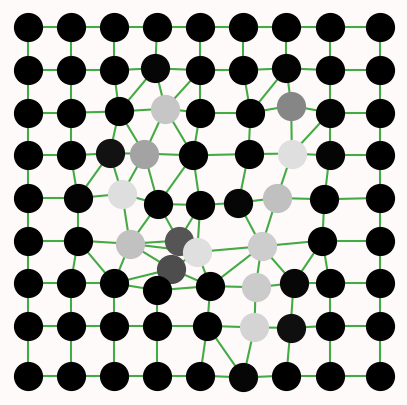

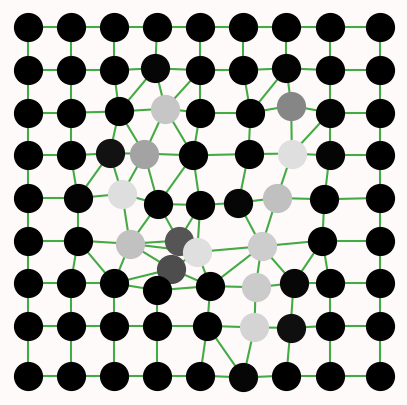

In [22]:
# use old function print
import numpy as np
pos = img_sp.x[:, :2].cpu().numpy()
# pos = np.flip(pos, 1)
rgb = img_sp.x[:, 2].cpu().unsqueeze(1).numpy()
draw_utils.draw_superpixel_from_graph(
    pos, rgb, img_sp.edge_index, multi_graph=False,
)

true 4
pred 3


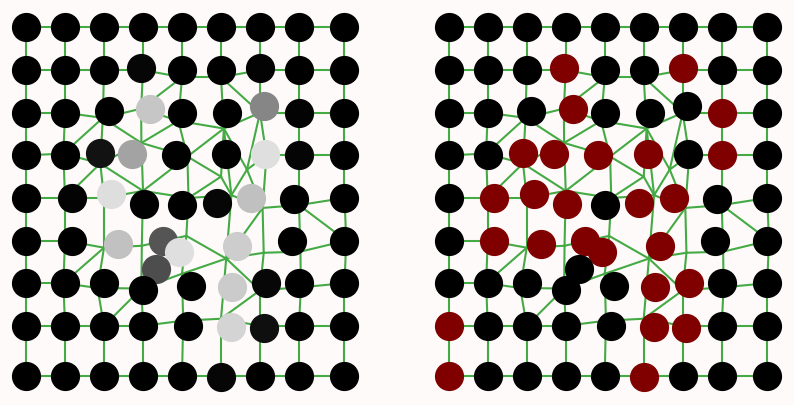

temp (3, 28, 28)


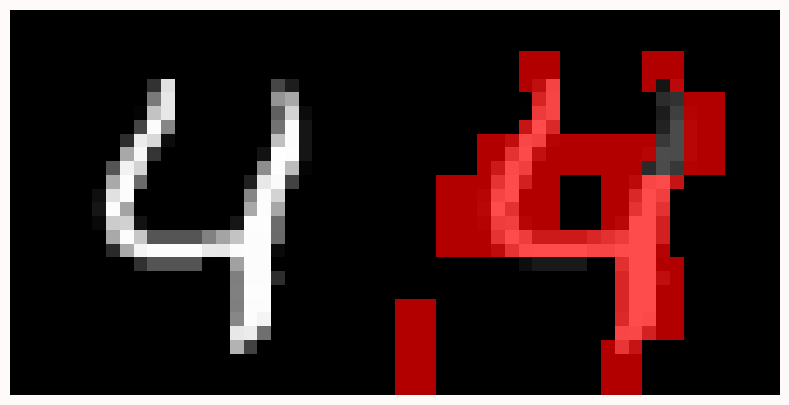

In [25]:
print('true', lbl)
print('pred', out.argmax(1).item())

# use old function print rgb and imp
pos = img_sp.x[:, :2].cpu().numpy()
# pos = np.flip(pos, 1)
rgb = img_sp.x[:, 2].cpu().unsqueeze(1).numpy()

imp = [[0, 0, 0] for _ in range(rgb.shape[0])]
for n in nodes_l1:
    imp[n][0] = 128

draw_utils.draw_superpixel_from_graph(
    pos, [rgb, imp], img_sp.edge_index,
    multi_graph=True,
)

img_temp = img_ori.numpy().copy()
img_temp = np.repeat(img_temp, 3, axis=0)
img_temp = img_temp * 0.3

print('temp', img_temp.shape)
for n in nodes_l1:
    m = node2map[n]
    img_temp[0, m] += 0.7

# img_temp = np.transpose(img_temp, (1, 2, 0))

img_ori_temp = np.repeat(img_ori, 3, axis=0)
img_out = np.concatenate([img_ori_temp, img_temp], axis=2)

draw_utils.show_original(img_out, width=15)